<a href="https://colab.research.google.com/github/Bakdaulet1/Bak-s/blob/master/Biking_MMM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introduction

**Mix Market Modelling** is a model employed by advertisers in order to evaluate advertising effectiveness and inform budget allocation. It allows you to (1) quantify the impact of advertising channels on your kpi and hence (2) optimize the budget allocaiton across them.

In this demo, I am going to use a fictitious dataset on bike sales and historical market spends in order to showcase the use of **LightWeightMMM** package for Python that uses Bayesian approach to mix market modelling using historical data as priors.


#2. Preparing the data

First step before we apply the package, we need to prepare the data. This involves cleaning the data and rescaling it, using the LightWeightMMM-innate scaling functions.

## 2.1. Cleaning the data

In [256]:
#Installing the LightWeight_MMM package
#!pip install lightweight_mmm
#Loading packages
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
import numpyro

In [257]:
#Loading the dataset
df = pd.read_csv("bike_sales_data.csv")

In [258]:
#Dropping duplicates
df = df.drop_duplicates()
df = df.dropna()

I am also going to convert the week column to date type to make it easier to work with it later.

In [259]:
df['date'] = pd.to_datetime(df['Week'], format='%m/%d/%y')
df = df.drop('Week', axis=1)

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sales                    260 non-null    float64       
 1   branded_search_spend     260 non-null    float64       
 2   nonbranded_search_spend  260 non-null    float64       
 3   facebook_spend           260 non-null    float64       
 4   print_spend              260 non-null    int64         
 5   ooh_spend                260 non-null    int64         
 6   tv_spend                 260 non-null    int64         
 7   radio_spend              260 non-null    int64         
 8   date                     260 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 20.3 KB


In [261]:
#Looking at the first 5 entries
df.head()

,sales,branded_search_spend,nonbranded_search_spend,facebook_spend,print_spend,ooh_spend,tv_spend,radio_spend,date
0,58850.0,1528.8,463.32,802.620,0,0,0,0,2017-07-23
1,62050.0,1575.6,468.00,819.312,0,0,0,0,2017-07-30
2,59388.0,1544.4,477.36,749.034,0,0,0,0,2017-08-06
3,56964.0,1528.8,468.00,741.468,0,0,0,0,2017-08-13
4,53460.0,1560.0,458.64,811.200,0,0,0,0,2017-08-20


There are no missing values and duplicates and data variable types look as desired. So we can proceed with further analysis.

## 2.2. Transforming the data

The necessary data for further analysis is the following:

1. **Media data**: Containing the metric per channel and time span (eg. impressions per time period). Media values must not contain negative values.
2. **Extra features**: Any other features that one might want to add to the analysis. These features need to be known ahead of time for optimization or you would need another model to estimate them.
3. **Target**: Target KPI for the model to predict. For example, revenue amount, number of app installs. This will also be the metric optimized during the optimization phase.
4. **Costs**: The total cost per media unit per channel.

Let's transform our data in order to obtain all 4 data.

1. **Media data** would be historical marketing spend for each category.

In [262]:
#df.set_index('date', inplace=True)
#Creating the media data.
media_data = df[['branded_search_spend', "nonbranded_search_spend",
                 'facebook_spend', 'print_spend',	'ooh_spend',
                 'tv_spend',	'radio_spend']].to_numpy()

2. The **target variable** or kpi in my case is bike sales.

In [263]:
target = df[['sales']].to_numpy()

3. I will also create some organic data that I would use as **extra features**.

In [264]:
extra_features = df[['sales']] + np.random.random_integers(10000, 100000, 1)
extra_features = extra_features.to_numpy()

<ipython-input-264-e35f0ab5d0eb>:1: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  extra_features = df[['sales']] + np.random.random_integers(10000, 100000, 1)


4. **Costs** will be just the sum of the expenses for each category of advertisement

In [265]:
costs = df[['branded_search_spend', "nonbranded_search_spend",
                 'facebook_spend', 'print_spend',	'ooh_spend',
                 'tv_spend',	'radio_spend']].sum().to_numpy()

As a next step, I am going to rescale the data using the package-innate **CustomScaler** function. I also define split_point variable which I would set to a date to get enough observations for testing.

In [313]:
data_size = media_data.shape[0]
split_point = data_size - 30

media_data_train = media_data[:split_point, :]
target_train = target[:split_point].reshape(-1)
extra_features_train = extra_features[:split_point, :].reshape(-1)
extra_features_test = extra_features[split_point:, :].reshape(-1)

# Scale data
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# scale cost up by N since fit() will divide it by number of time periods
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

Now that we preprocessed and rescaled the data, we can proceed with training the model.



# 3. Training the model

Now I am going to train the model. It requires passing the **media data, extra features, target** kpi as well as costs that we would use as priors. I also set both the number of warmups and samples to 100.

Because the effect of each advertising stream is likely to be lagged and taper off over time, we need to account for this dynamic effect. While the package offers three different functional forms to model this behavior, we opt for **carryover** method. The essense of this form is that temporally close values of input channel have more weight than distant ones.

In [318]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

In [319]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    number_warmup=100,
    number_samples=100,
    number_chains=1,
    )

sample: 100%|██████████| 200/200 [01:35<00:00,  2.10it/s, 1023 steps of size 4.94e-03. acc. prob=0.70]


# 3.1. Model Diagnostics

To get the detail of parameter estimations, let's condider the summary of the model.

In [320]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.56      0.06      0.56      0.49      0.69     13.29      0.99
ad_effect_retention_rate[1]      0.60      0.18      0.59      0.30      0.85      9.52      1.34
ad_effect_retention_rate[2]      0.54      0.14      0.53      0.32      0.72      2.88      2.31
ad_effect_retention_rate[3]      0.85      0.11      0.89      0.65      0.99      3.32      1.66
ad_effect_retention_rate[4]      0.70      0.16      0.74      0.47      0.93      3.24      1.64
ad_effect_retention_rate[5]      0.43      0.21      0.45      0.04      0.74      5.25      1.28
ad_effect_retention_rate[6]      0.45      0.25      0.41      0.05      0.79     18.78      1.02
              coef_media[0]      0.20      0.11      0.17      0.03      0.33      6.43      1.31
              coef_media[1]      0.20      0.05      0.20      0.14      0.29     74.88      1.00
              coef_

The rule of thumb is that **r_hats** have to be below 1.1. Now let's evaluate the fit of our model. Let's extract media effectiveness and ROI and plot them.

Let's check how well our model predicts the true KPI but plotting predicted KPI versus true KPI.

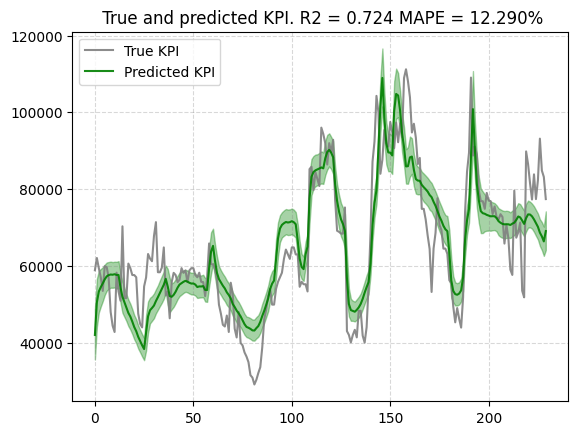

In [304]:
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)

High **R-squared** of 0.724 gives us confidence in our model, so I proceed with analysis further.

## 3.2. Media insights

In this section, I will explore how much each media stream impact sales.

First, I look at the response curves which plots normalized spend versus KPI.

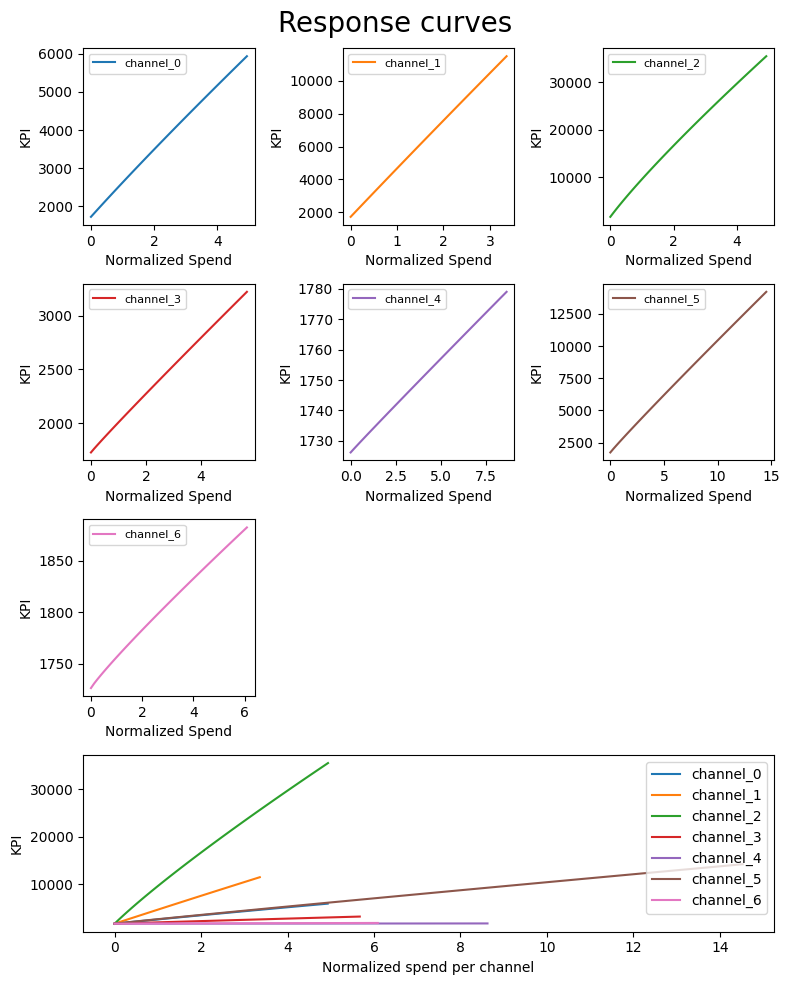

In [290]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler)

You can see that **facebook_spend** followed by **unbranded_search_spend** generate the highest KPI increment per extra dollar spent.

Now I proceed with two other metrics - **ROI** and **media effectifeness**.

In [285]:
media_effect_hat, roi_hat = mmm.get_posterior_metrics()

In [286]:
#Setting media_names that we would use later for graphing purposes
media_names = ['branded_search_spend', "nonbranded_search_spend",
                 'facebook_spend', 'print_spend',	'ooh_spend',
                 'tv_spend',	'radio_spend']

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/plot.py:859: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric, ci=None, ax=ax)


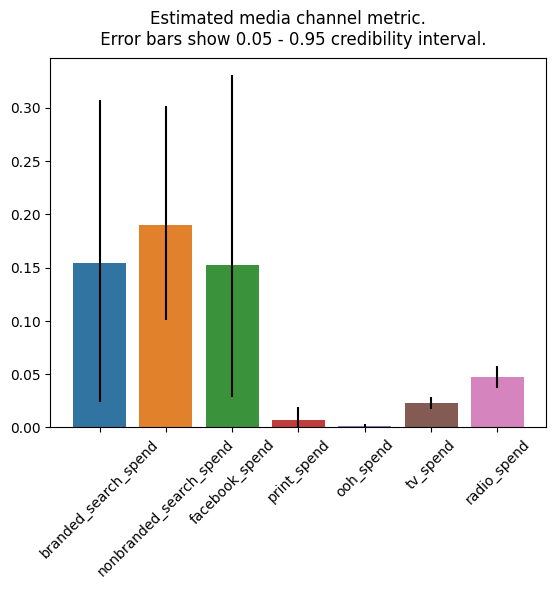

In [287]:
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/plot.py:859: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric, ci=None, ax=ax)


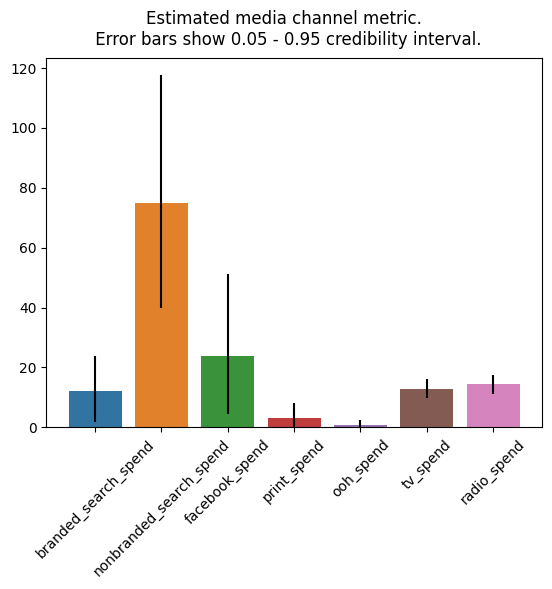

In [288]:
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)

Now let's plot the contribution of each media channel over time.

In [325]:
from matplotlib import pyplot as plt
import numpy as np

def custom_plot_media_baseline_contribution_area_plot(
        media_mix_model,
        target_scaler=None,
        channel_names=None,
        fig_size = (20, 7)):
      """Plots an area chart to visualize weekly media & baseline contribution.

      Args:
        media_mix_model: Media mix model.
        target_scaler: Scaler used for scaling the target.
        channel_names: Names of media channels.
        fig_size: Size of the figure to plot as used by matplotlib.

      Returns:
        Stacked area chart of weekly baseline & media contribution.
      """
      # Create media channels & baseline contribution dataframe.
      contribution_df = plot.create_media_baseline_contribution_df(
          media_mix_model=media_mix_model,
          target_scaler=target_scaler,
          channel_names=media_names)
      contribution_df = contribution_df.clip(0)

      # Create contribution dataframe for the plot.
      contribution_columns = [
          col for col in contribution_df.columns if "contribution" in col
      ]
      contribution_df_for_plot = contribution_df.loc[:, contribution_columns]
      contribution_df_for_plot = contribution_df_for_plot[
          contribution_df_for_plot.columns[::-1]]
      period = np.arange(1, contribution_df_for_plot.shape[0] + 1)
      contribution_df_for_plot.loc[:, "period"] = period

      # Plot the stacked area chart.
      fig, ax = plt.subplots()
      contribution_df_for_plot.plot.area(
          x="period", stacked=True, figsize=fig_size, ax=ax)
      ax.set_title("Attribution Over Time", fontsize="x-large")
      ax.tick_params(axis="y")
      ax.set_ylabel("Baseline & Media Chanels Attribution")
      ax.set_xlabel("Period")
      ax.set_xlim(1, contribution_df_for_plot["period"].max())
      ax.set_xticks(contribution_df_for_plot["period"])
      ax.set_xticklabels(contribution_df_for_plot["period"])
      for tick in ax.get_xticklabels():
        tick.set_rotation(45)
      plt.close()
      return fig

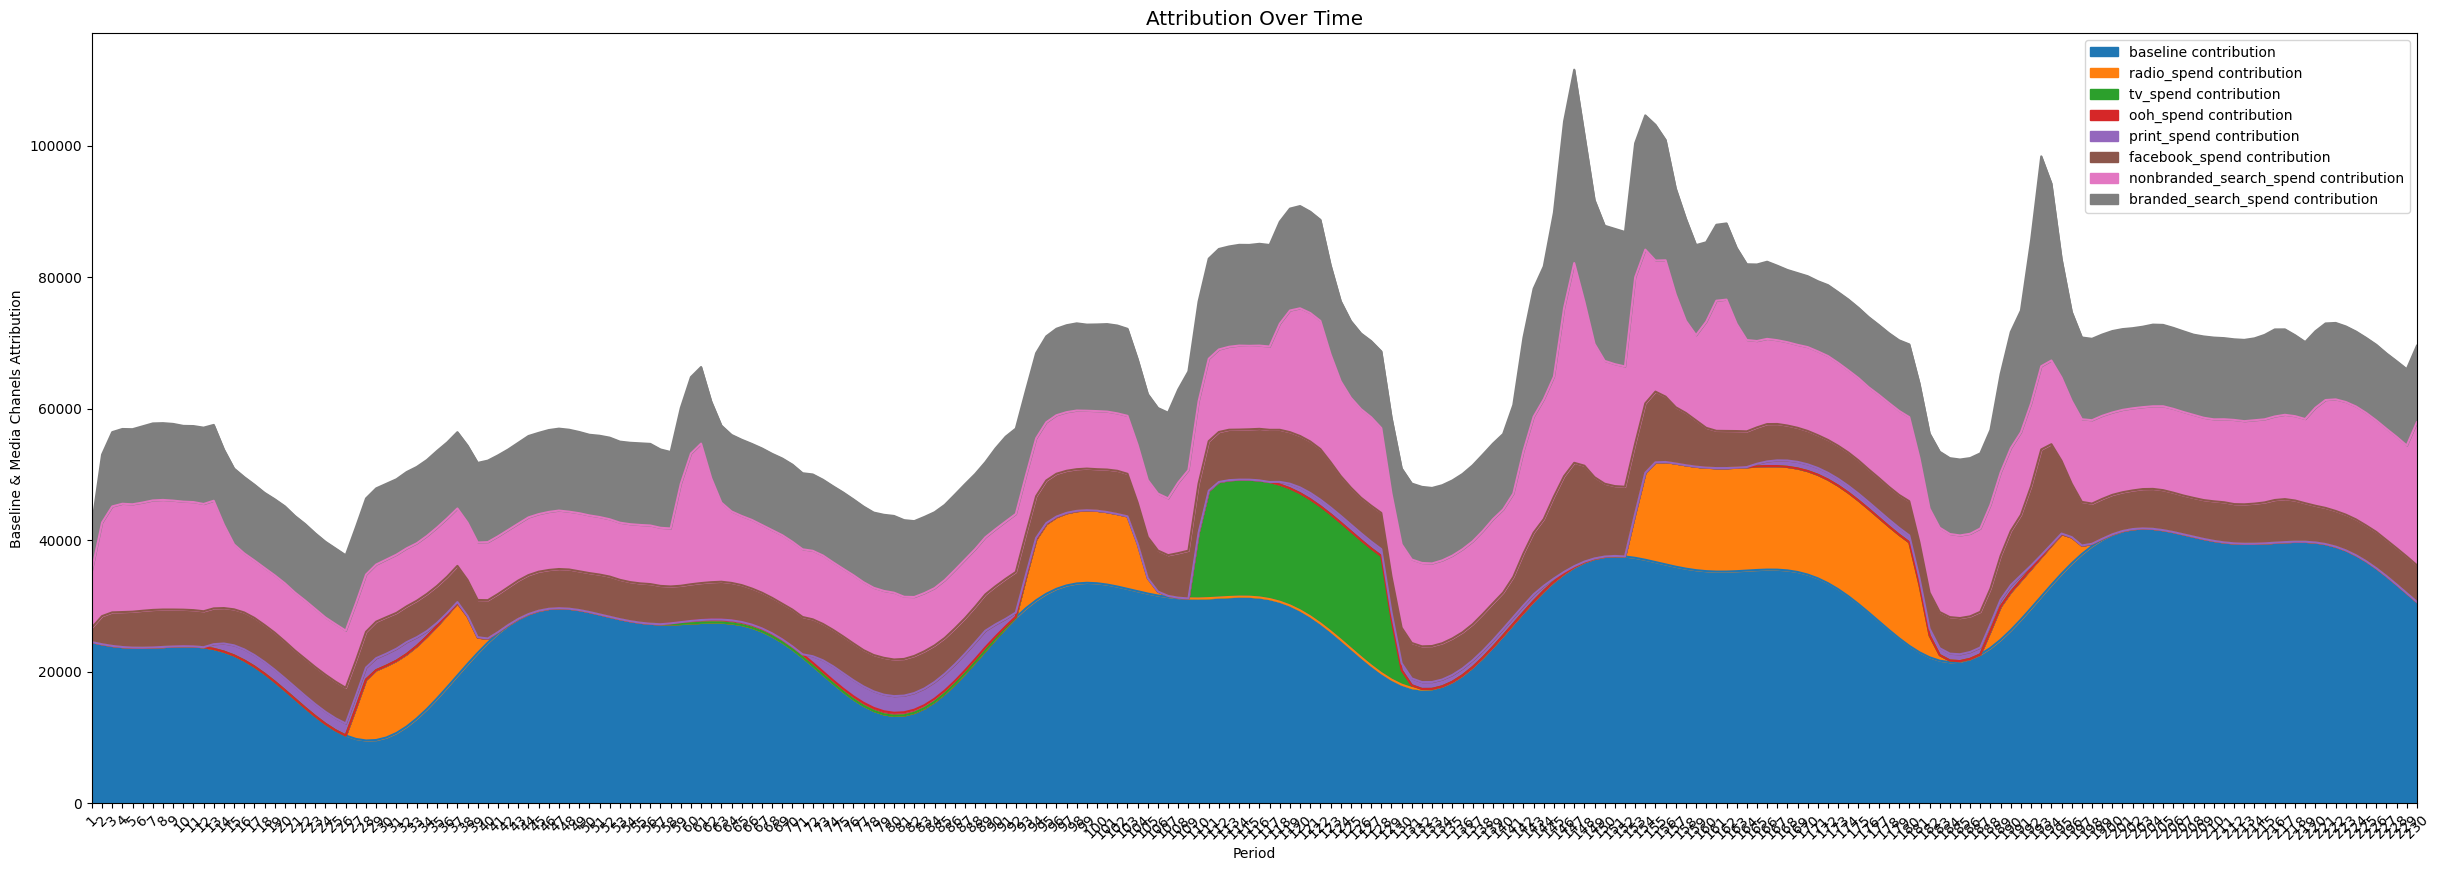

In [326]:
custom_plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

You can see that the **nonbranded_search_spend** and **branded_search_spend** streams contributed proportionally the most to generating the sales over the historical time period.

# 4. Optimization of the Budget

## 4.1. Finding optimal allocation

**Budget optimization** entails finding the combination of media stream allocation that maximizes sales subject to budget restriction. Note we are optimizing over different media channels, not over time.

I am setting prices vector to a unit vector for testing reasons.

In [291]:
 prices = jnp.ones(mmm.n_media_channels)

Let's optimize for 10 weeks and set the budget to the
amount that we would spend if we were to spend an average historic amount in 10 weeks. This would be equal to the mean expenditure over time summed across different advertising streams times 10 weeks.

In [305]:
n_time_periods = 10 # this is the number of period we want simulate
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [293]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -713897.1855831979
            Iterations: 20
            Function evaluations: 285
            Gradient evaluations: 19


Now, we can get the optimal allocation of the budget across different channels by multiplying the price of the channel by the solutions.

In [294]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([19352.225 ,  4231.6924, 11376.33  ,  2539.1304,  1113.0433,
        2478.2612,  7095.6533], dtype=float32)

## 4.2. Budget allocation comparison

Let's also compare the budget allocation before and after optimization of the budget.

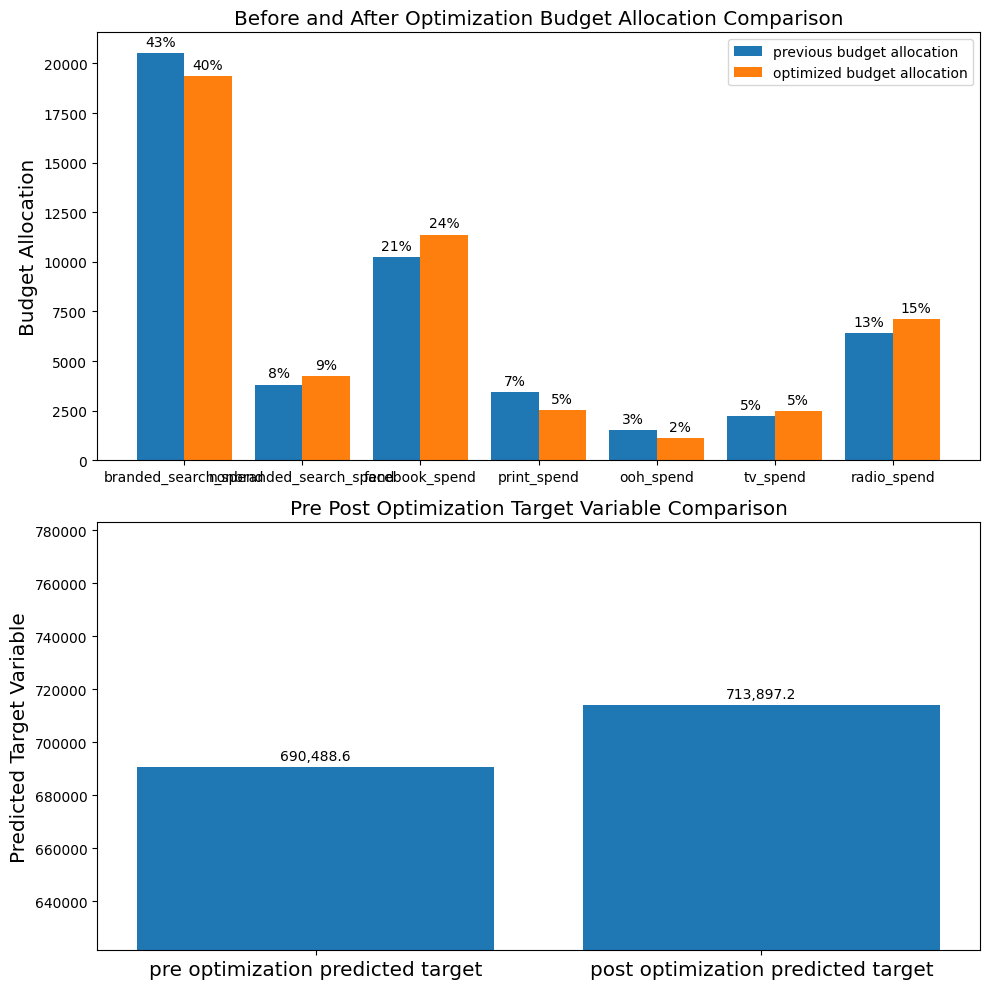

In [301]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                channel_names=media_names,
                                                figure_size=(10,10))

As you can see, the optimization would allow us to generate a higher volume of sales.